In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Logistic Regression

In [3]:
# preprocessing : 股價的漲 (1) or 跌 (0) label
def add_label(df, column):
    label = []
    for i in range(len(df)):
        if(i == 0):
            label.append(0)
            continue
        if(df[column][i] >= df[column][i - 1]):
            label.append(1)
        else:
            label.append(0)
    return pd.Series(label)
    
train_length = len(train)
train["label"] = add_label(train, "Close Price")
test["label"] = add_label(test, "Close Price")
train.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,label
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,0
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,0
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,1
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,0
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,1


In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# 取出參考的 columns
x_list = ["Open Price", "Close Price", "High Price", "Low Price", "Volume"]
train_x = train[x_list]
train_y = train["label"]

test_x = test[x_list]
test_y = test["label"]

print("Train size: %d, Test size: %d" % (len(train), len(test)))

# train model & predict
model = LogisticRegression()
model.fit(train_x, train_y)

pred_y = model.predict(test_x)
print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_y, test_y) * 100, 2)) + " %" )

C:\Users\1234\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train size: 2264, Test size: 252
accuracy : 52.38 %


## Neural Network - 1

透過股價直接預測分類(漲 or 跌)

<br/>
reference :
- [股票LSTM分析(2)-Classifiacion](https://mc.ai/%E8%82%A1%E7%A5%A8lstm%E5%88%86%E6%9E%902-classifiacion/)
- [Keras](https://keras.io/zh/getting-started/sequential-model-guide/)

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train = train.drop(["Date"], axis=1)
test = test.drop(["Date"], axis=1)

train["label"] = add_label(train, "Close Price")
test["label"] = add_label(test, "Close Price")

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 

x_list = ["Open Price", "Close Price", "High Price", "Low Price"]

# 正規化
scaler = MinMaxScaler()
train[x_list] = scaler.fit_transform(train[x_list])
train.head()

,Open Price,Close Price,High Price,Low Price,Volume,label
0,0.111109,0.126771,0.119748,0.115178,4048270080,0
1,0.124112,0.124611,0.120698,0.125173,5413910016,0
2,0.125105,0.128211,0.124309,0.129011,5392620032,1
3,0.123257,0.114281,0.116107,0.116674,4704940032,0
4,0.112470,0.115811,0.107381,0.113920,4991549952,1


In [7]:
# 以 5 天為單位當作一個輸入資料
def extract_days(df, ref_day = 5, predict_day = 1):
    X_train, Y_train = [], []
    tmp = df[["Open Price", "Close Price", "High Price", "Low Price"]]
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(tmp.iloc[i: i + ref_day,: ]))
        Y_train.append(np.array(df["label"][i + ref_day: i + ref_day + predict_day,]))
    return np.array(X_train), np.array(Y_train)

train_x, train_y = extract_days(train, 5, 1)
test_x, test_y = extract_days(test, 5, 1)

print("finish")

finish


In [8]:
print("train_x set shape: ", str(train_x.shape))
print("train label 0 v.s. 1 :", end=" ")
print(list(train_y).count(0), list(train_y).count(1))

print("- - -")

print("test_x set shape: ", str(test_x.shape))
print("test  label 0 v.s. 1 :", end=" ")
print(list(test_y).count(0), list(test_y).count(1))

train_x set shape:  (2258, 5, 4)
train label 0 v.s. 1 : 1021 1237
- - -
test_x set shape:  (246, 5, 4)
test  label 0 v.s. 1 : 119 127


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (train_x.shape[1], train_x.shape[2])))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 30, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 30))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1, activation='sigmoid'))
regressor.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
regressor.fit(train_x, train_y, epochs = 10, batch_size = 64)

print("finish")

Using TensorFlow backend.
W0527 23:03:31.760421 22880 deprecation.py:323] From C:\Users\1234\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0527 23:03:33.880220 22880 deprecation_wrapper.py:119] From C:\Users\1234\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/10
2258/2258 [==============================] - 2s 802us/step - loss: 0.6907 - accuracy: 0.5500
Epoch 2/10
2258/2258 [==============================] - 0s 216us/step - loss: 0.6909 - accuracy: 0.5483
Epoch 3/10
2258/2258 [==============================] - 0s 219us/step - loss: 0.6902 - accuracy: 0.5461
Epoch 4/10
2258/2258 [==============================] - 0s 219us/step - loss: 0.6893 - accuracy: 0.5478
Epoch 5/10
2258/2258 [==============================] - 0s 208us/step - loss: 0.6886 - accuracy: 0.5474
Epoch 6/10
2258/2258 [==============================] - 1s 223us/step - loss: 0.6902 - accuracy: 0.5478
Epoch 7/10
2258/2258 [==============================] - 0s 214us/step - loss: 0.6892 - accuracy: 0.5478
Epoch 8/10
2258/2258 [==============================] - 1s 235us/step - loss: 0.6880 - accuracy: 0.5478
Epoch 9/10
2258/2258 [==============================] - 1s 249us/step - loss: 0.6891 - accuracy: 0.5478
Epoch 10/10
2258/2258 [==============================] - 1s 231u

In [10]:
predict_y = regressor.predict(test_x)
predict_y = pd.DataFrame(predict_y).values.astype(float)
print("finish")

finish


In [11]:
def convert_to_label(predict):
    data = []
    for i in range(len(predict)):
        if(predict_y[i] > 0.5):
            data.append(1)
        else:
            data.append(0)
    return data
pred_yy = np.array(convert_to_label(predict_y))

# 預測結果偏向某一類型
pred_yy

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [12]:
print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_yy, test_y) * 100, 2)) + " %" )

accuracy : 51.63 %


### Nuural Network - 2
透過股價預測股價，然後再轉換成漲或跌的趨勢分類  

<br/>
reference : [實作透過lstm預測股票](https://wenwender.wordpress.com/2019/10/18/%E5%AF%A6%E4%BD%9C%E9%80%8F%E9%81%8Elstm%E9%A0%90%E6%B8%AC%E8%82%A1%E7%A5%A8/)

In [13]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [14]:
from sklearn.preprocessing import MinMaxScaler 

train_set = train[['Close Price']]
test_set = test[['Close Price']]

# preprocessing: 資料正規化
sc = MinMaxScaler(feature_range = (0, 1))
train_set= train_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(train_set)

train_x, train_y = [], []
# 以 5 天當作一個單位
for i in range(5, len(train_set)):
    train_x.append(training_set_scaled[i-5: i, 0]) 
    train_y.append(training_set_scaled[i:i+1, 0]) 
    
train_x, train_y = np.array(train_x), np.array(train_y) 
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))

print("finish")

finish


In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,BatchNormalization

keras.backend.clear_session()
regressor = Sequential()
regressor.add(LSTM(units = 50, input_shape = (train_x.shape[1], 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = regressor.fit(train_x, train_y, epochs = 40, batch_size = 16)
print("finish")

Epoch 1/40
2259/2259 [==============================] - 1s 482us/step - loss: 0.0214
Epoch 2/40
2259/2259 [==============================] - 1s 307us/step - loss: 2.1693e-04
Epoch 3/40
2259/2259 [==============================] - 1s 303us/step - loss: 1.9192e-04
Epoch 4/40
2259/2259 [==============================] - 1s 290us/step - loss: 1.6307e-04
Epoch 5/40
2259/2259 [==============================] - 1s 300us/step - loss: 1.4771e-04
Epoch 6/40
2259/2259 [==============================] - 1s 299us/step - loss: 1.3893e-04
Epoch 7/40
2259/2259 [==============================] - 1s 269us/step - loss: 1.3981e-04
Epoch 8/40
2259/2259 [==============================] - 1s 320us/step - loss: 1.3297e-04
Epoch 9/40
2259/2259 [==============================] - 1s 337us/step - loss: 1.3240e-04
Epoch 10/40
2259/2259 [==============================] - 1s 323us/step - loss: 1.2621e-04
Epoch 11/40
2259/2259 [==============================] - 1s 279us/step - loss: 1.3253e-04
Epoch 12/40
2259/2259 [

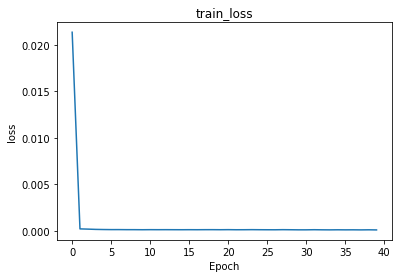

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# loss graph
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot( history.history["loss"])

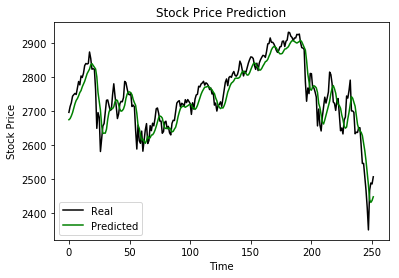

In [18]:
dataset_total = pd.concat((train['Close Price'], test['Close Price']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

test_x = []
for i in range(5, len(inputs)):
    test_x.append(inputs[i-5: i, 0])
test_x = np.array(test_x)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
predicted_stock_price = regressor.predict(test_x)
# 將股價轉為原本的範圍區間
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# 預測股價趨勢圖
plt.plot(test['Close Price'].values, color = 'black', label = 'Real')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [19]:
# 將股價狀態轉為趨勢分類
def label_convert(train):
    data = []
    for i in range(len(train) - 5):
        if (i == 0):
            data.append(0)
            continue
        if train[i + 5] > train[i] :
            data.append(1)
        else:
            data.append(0)
    return data

ans1 = label_convert(predicted_stock_price)
ans2 = label_convert(test["Close Price"])

print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(ans1, ans2) * 100, 2)) + " %" )

accuracy : 69.23 %


## Random Forest Classifier

第三種模型測試(1)

In [20]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train["label"] = add_label(train, "Close Price")
test["label"] = add_label(test, "Close Price")

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, ensemble, preprocessing, metrics

nor_list = ["Open Price", "Close Price", "High Price", "Low Price", "Volume"]

train_x, train_y = train[nor_list], train["label"]
test_x, test_y = test[nor_list], test["label"]

model = RandomForestClassifier(n_estimators = 10)
model.fit(train_x, train_y)

pred_y = model.predict(test_x)
print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_y, test_y) * 100, 2)) + " %" )

accuracy : 53.17 %


C:\Users\1234\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## SVM

第三種模型測試(2)

In [22]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(train_x, train_y)
pred_y = svm.predict(test_x)

print("accuracy :", end=" ")
print(str(round(metrics.accuracy_score(pred_y, test_y) * 100, 2)) + " %" )

accuracy : 52.38 %
